**Notebook to investigate the Young Stellar Object R CrA in Corona Australis with ALMA and other archival data** \
More information on querying the ALMA archive programatically: \
https://almascience.eso.org/alma-data/archive/archive-notebooks \
Documentation for *astroquery*: \
https://astroquery.readthedocs.io/

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from astroquery.simbad import Simbad
from astroquery.alma import Alma
from astropy import coordinates
from astropy.io import fits
import astropy.units as u
import aplpy
from geometry import *

In [18]:
# Query Simbad by source name and retrieve coordinates, likely from YSO in the optical or near-IR
result_table = Simbad.query_object("R CrA")
result_table.pprint()
RA_Simbad = result_table['RA']
Dec_Simbad = result_table['DEC']

MAIN_ID        RA           DEC      ... COO_WAVELENGTH     COO_BIBCODE     SCRIPT_NUMBER_ID
            "h:m:s"       "d:m:s"    ...                                                    
-------- ------------- ------------- ... -------------- ------------------- ----------------
V* R CrA 19 01 53.6764 -36 57 08.299 ...              O 2020yCat.1350....0G                1


In [19]:
# Also, define coordinates of YSO from VLA data. 
# Reference: Liu, Galván-Madrid, Forbrich et al. (2014)
# https://ui.adsabs.harvard.edu/abs/2014ApJ...780..155L/abstract 
RA_VLA = "19h01m53.686s"
Dec_VLA = "-36d57m08.0s"
c = coordinates.SkyCoord(RA_VLA, Dec_VLA, frame='icrs')
r = 1 * u.arcsec
result_table = Simbad.query_region(c, radius=r)
result_table.pprint()

MAIN_ID        RA           DEC      ... COO_WAVELENGTH     COO_BIBCODE     SCRIPT_NUMBER_ID
            "h:m:s"       "d:m:s"    ...                                                    
-------- ------------- ------------- ... -------------- ------------------- ----------------
V* R CrA 19 01 53.6764 -36 57 08.299 ...              O 2020yCat.1350....0G                1


In [20]:
# Start digging in the ALMA archive, first check what we can do: 
Alma.help()
#Instantiate object for query: 
alma = Alma()


Most common ALMA query keywords are listed below. These keywords are part of the ALMA ObsCore model, an IVOA standard for metadata representation (3rd column). They were also present in original ALMA Web form and, for backwards compatibility can be accessed with their old names (2nd column).
More elaborate queries on the ObsCore model are possible with `query_sia` or `query_tap` methods
  Description                       Original ALMA keyword               ObsCore keyword                    
-------------------------------------------------------------------------------------------------------

Position
  Source name (astropy Resolver)    source_name_resolver                SkyCoord.from_name                 
  Source name (ALMA)                source_name_alma                    target_name                        
  RA Dec (Sexagesimal)              ra_dec                              s_ra, s_dec                        
  Galactic (Degrees)                galactic                   

In [21]:
# Define parameters for data query
# help(alma_data.query) 
band_list = [3]
spatial_resolution = 2.0*u.arcsec
search_radius = 65*u.arcsec

In [22]:
# Make data query: 
alma_data = alma.query_region(c, search_radius, band_list=band_list).to_pandas()
print(alma_data)
#print(len(alma_data.colnames))
#print(alma_data.colnames)
alma_data.to_csv('test_query_region.csv')

              obs_publisher_did obs_collection facility_name instrument_name  \
0   ADS/JAO.ALMA#2019.1.01074.S           ALMA           JAO            ALMA   
1   ADS/JAO.ALMA#2019.1.01074.S           ALMA           JAO            ALMA   
2   ADS/JAO.ALMA#2019.1.01074.S           ALMA           JAO            ALMA   
3   ADS/JAO.ALMA#2019.1.01074.S           ALMA           JAO            ALMA   
4   ADS/JAO.ALMA#2018.1.01205.L           ALMA           JAO            ALMA   
5   ADS/JAO.ALMA#2018.1.01205.L           ALMA           JAO            ALMA   
6   ADS/JAO.ALMA#2018.1.01205.L           ALMA           JAO            ALMA   
7   ADS/JAO.ALMA#2018.1.01205.L           ALMA           JAO            ALMA   
8   ADS/JAO.ALMA#2018.1.01205.L           ALMA           JAO            ALMA   
9   ADS/JAO.ALMA#2018.1.01205.L           ALMA           JAO            ALMA   
10  ADS/JAO.ALMA#2018.1.01205.L           ALMA           JAO            ALMA   
11  ADS/JAO.ALMA#2018.1.01205.L         

In [23]:
# Make a new, more refined query using TAP
# The format is a bit annoying but this is the most flexible way to query

alma_data = alma.query_tap(f"select * from ivoa.obscore where intersects(circle('ICRS',{c.ra.degree},"
                           f"{c.dec.degree},{search_radius.to('deg').value}),s_region)=1 and " 
                           f"band_list={band_list[0]} and spatial_resolution<={spatial_resolution.value}"
                          ).to_table().to_pandas()
print(alma_data)
alma_data.to_csv("test_query_tap.csv")

              obs_publisher_did obs_collection facility_name instrument_name  \
0   ADS/JAO.ALMA#2019.1.01074.S           ALMA           JAO            ALMA   
1   ADS/JAO.ALMA#2019.1.01074.S           ALMA           JAO            ALMA   
2   ADS/JAO.ALMA#2019.1.01074.S           ALMA           JAO            ALMA   
3   ADS/JAO.ALMA#2019.1.01074.S           ALMA           JAO            ALMA   
4   ADS/JAO.ALMA#2018.1.01205.L           ALMA           JAO            ALMA   
5   ADS/JAO.ALMA#2018.1.01205.L           ALMA           JAO            ALMA   
6   ADS/JAO.ALMA#2018.1.01205.L           ALMA           JAO            ALMA   
7   ADS/JAO.ALMA#2018.1.01205.L           ALMA           JAO            ALMA   
8   ADS/JAO.ALMA#2018.1.01205.L           ALMA           JAO            ALMA   
9   ADS/JAO.ALMA#2018.1.01205.L           ALMA           JAO            ALMA   
10  ADS/JAO.ALMA#2018.1.01205.L           ALMA           JAO            ALMA   
11  ADS/JAO.ALMA#2018.1.01205.L         

In [24]:
# Preparation for download 
alma.cache_location = '/home/roberto/YSOs/RCrA/'
alma.archive_url = 'https://almascience.eso.org'
uids = np.unique(alma_data['member_ous_uid'])
print(uids)
link_list = alma.get_data_info(uids, expand_tarfiles=True)
print('Total number of links available for download {}'.format(len(link_list)))
print(link_list)

['uid://A001/X1354/X240' 'uid://A001/X1354/X242' 'uid://A001/X1465/X1aca'
 'uid://A001/X2d1f/Xb26']
Total number of links available for download 783
                        ID                         ... link_authorized
                                                   ...                
-------------------------------------------------- ... ---------------
                             uid://A001/X1354/X240 ...            True
                             uid://A001/X1354/X240 ...            True
                             uid://A001/X1354/X240 ...            True
                             uid://A001/X1354/X240 ...            True
                             uid://A001/X1354/X240 ...            True
                             uid://A001/X1354/X240 ...            True
                             uid://A001/X1354/X242 ...            True
                                               ... ...             ...
2022.1.00131.S_uid___A001_X2d1f_Xb26_auxiliary.tar ...            True

In [25]:
# First, download the README files of the likely many data sets: 
readmes = [url for url in link_list['access_url'] if 'README' in url]
result = alma.download_files(readmes, cache=True) 

INFO: Found cached file /home/roberto/YSOs/RCrA/member.uid___A001_X1354_X240.README.txt with expected size 3524. [astroquery.query]
INFO: Found cached file /home/roberto/YSOs/RCrA/member.uid___A001_X1354_X242.README.txt with expected size 3524. [astroquery.query]
INFO: Found cached file /home/roberto/YSOs/RCrA/member.uid___A001_X1465_X1aca.README.txt with expected size 3524. [astroquery.query]
INFO: Found cached file /home/roberto/YSOs/RCrA/member.uid___A001_X2d1f_Xb26.README.txt with expected size 3524. [astroquery.query]


In [26]:
# Second, define download only the QA2 FITS images and README files
#
fits_urls = [url for url in link_list['access_url'] if 'CrA' in url and '.pbcor.fits' in url and 
                'tt1' not in url]
#
print('Total number of FITS files after selection criteria: {}'.format(len(fits_urls)))
fits_label = list(range(len(fits_urls)))
for i in range(len(fits_urls)):
    print(i, end = ' ')
    print(fits_urls[i], end = '\n') 

Total number of FITS files after selection criteria: 129
0 https://almascience.nrao.edu/dataPortal/member.uid___A001_X1354_X240.R_CrA_IRS7B_sci.spw25.cube.I.pbcor.fits
1 https://almascience.nrao.edu/dataPortal/member.uid___A001_X1354_X240.R_CrA_IRS7B_sci.spw25.mfs.I.pbcor.fits
2 https://almascience.nrao.edu/dataPortal/member.uid___A001_X1354_X240.R_CrA_IRS7B_sci.spw25_27_29_31_33_35_37.cont.I.tt0.pbcor.fits
3 https://almascience.nrao.edu/dataPortal/member.uid___A001_X1354_X240.R_CrA_IRS7B_sci.spw27.cube.I.pbcor.fits
4 https://almascience.nrao.edu/dataPortal/member.uid___A001_X1354_X240.R_CrA_IRS7B_sci.spw27.mfs.I.pbcor.fits
5 https://almascience.nrao.edu/dataPortal/member.uid___A001_X1354_X240.R_CrA_IRS7B_sci.spw29.cube.I.pbcor.fits
6 https://almascience.nrao.edu/dataPortal/member.uid___A001_X1354_X240.R_CrA_IRS7B_sci.spw29.mfs.I.pbcor.fits
7 https://almascience.nrao.edu/dataPortal/member.uid___A001_X1354_X240.R_CrA_IRS7B_sci.spw31.cube.I.pbcor.fits
8 https://almascience.nrao.edu/dataP

In [27]:
# Do the download: 
files_to_download = [2,17,31,38,69,100]
#files_to_download = [2,17]
download_paths = []
for file in files_to_download:
    download = alma.download_files([fits_urls[file]], cache=True) 
    download_paths.append(download[0])
print('Download paths are:')
print(download_paths)

INFO: Found cached file /home/roberto/YSOs/RCrA/member.uid___A001_X1354_X240.R_CrA_IRS7B_sci.spw25_27_29_31_33_35_37.cont.I.tt0.pbcor.fits with expected size 16030080. [astroquery.query]
INFO: Found cached file /home/roberto/YSOs/RCrA/member.uid___A001_X1354_X242.R_CrA_IRS7B_sci.spw25_27_29_31_33_35_37.cont.I.tt0.pbcor.fits with expected size 1195200. [astroquery.query]
INFO: Found cached file /home/roberto/YSOs/RCrA/member.uid___A001_X1465_X1aca.RCrA_IRS7B_sci.spw21_23_25_27.cont.I.tt0.pbcor.fits with expected size 33206400. [astroquery.query]
INFO: Found cached file /home/roberto/YSOs/RCrA/member.uid___A001_X2d1f_Xb26.RCrA_IRAS32_sci.spw23_25_27_29_31_33_35_37_39_41_43_45_47_49_51.cont.I.tt0.pbcor.fits with expected size 1359360. [astroquery.query]
INFO: Found cached file /home/roberto/YSOs/RCrA/member.uid___A001_X2d1f_Xb26.RCrA_IRS5N_sci.spw23_25_27_29_31_33_35_37_39_41_43_45_47_49_51.cont.I.tt0.pbcor.fits with expected size 1359360. [astroquery.query]
INFO: Found cached file /home/

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


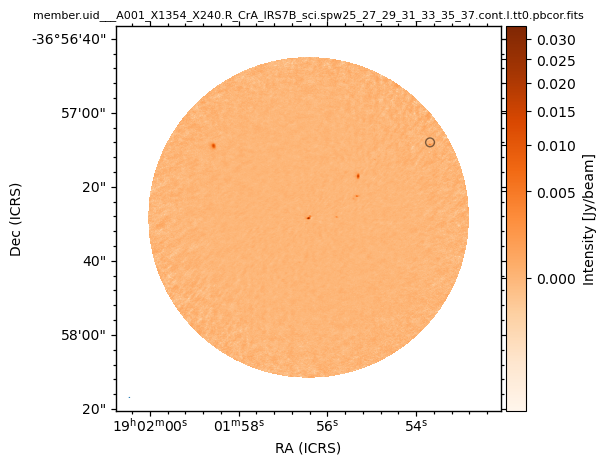

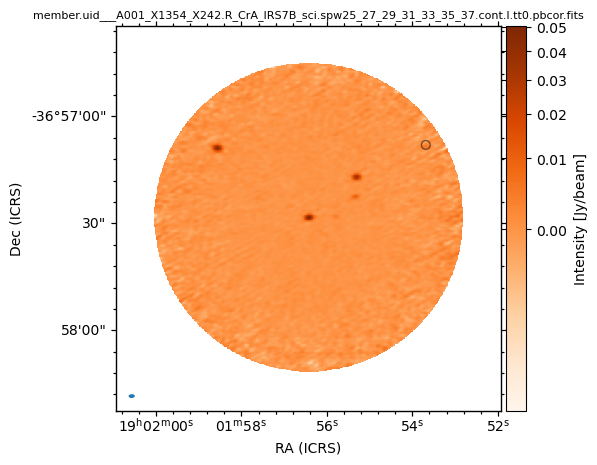

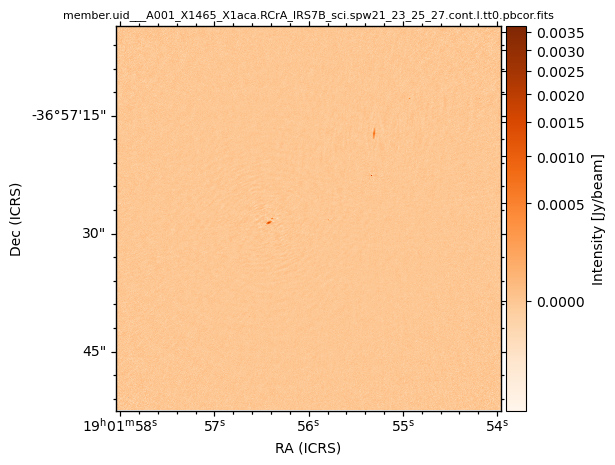

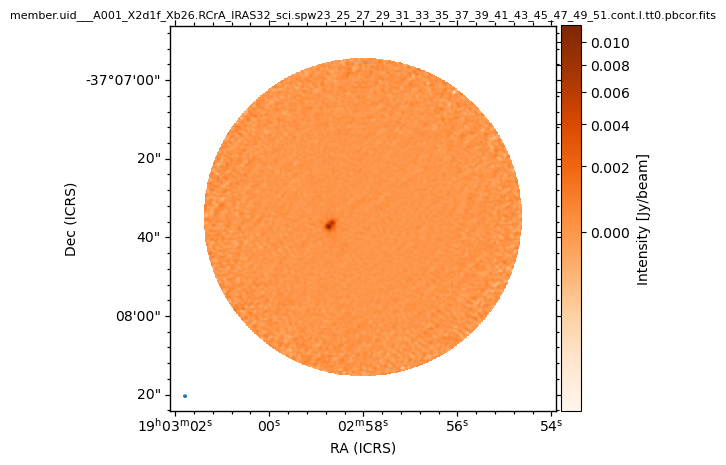

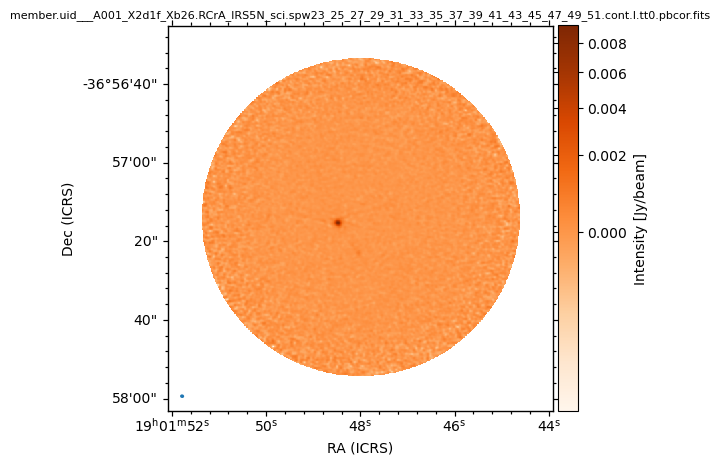

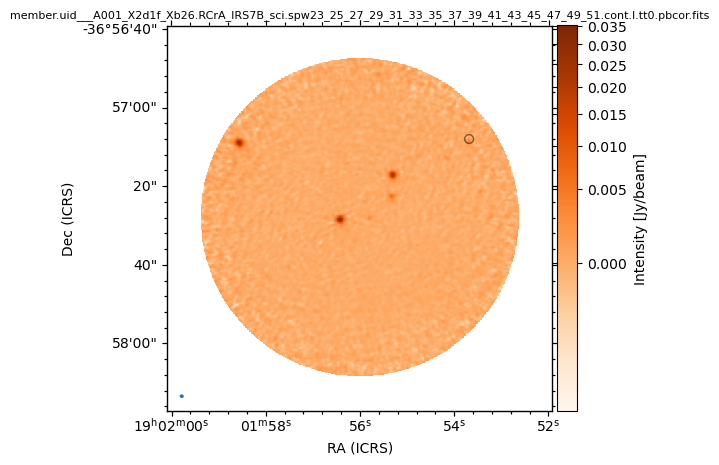

In [33]:
for image_file in download_paths:
    im_upd = updatefits(image_file, 0)
    #Read min/max and other params
    data = im_upd.data
    max = np.nanmax(data)
    min = np.nanmin(data)
    header = im_upd.header
    #Call plotting
    fig = plt.figure(figsize=(6, 5)) 
    fig = aplpy.FITSFigure(im_upd, figure=fig)
    fig.show_colorscale(cmap='Oranges',stretch='power', exponent=1/3,vmax=max,vmin=min)
    fig.show_markers(c.ra, c.dec, edgecolor='black',facecolor='none', marker='o', s=40, alpha=0.5)
    #f1.add_label(0.15,0.9,field,relative=True,color='white',size=20)
    fig.set_title(image_file.split('/')[-1], fontsize=8)
    fig.add_colorbar()
    fig.colorbar.show()
    fig.colorbar.set_location('right')
    fig.colorbar.set_font(size=10)
    fig.colorbar.set_axis_label_text('Intensity [Jy/beam]')
    fig.colorbar.set_axis_label_font(size=10) #weight='bold'
    fig.add_beam()
    fig.axis_labels.set_font(size=10)   
    fig.tick_labels.set_font(size=10)  
    fig.savefig(image_file.replace('.fits','.png'), dpi=150, adjust_bbox=True)


In [30]:
'''
For plotting, there is nasty incompatibility issue between astropy 5.1.0 and matplotlib 3.7.0. 
If you have the following error, update to astropy 5.1.1 or later: 
https://github.com/astropy/astropy/issues/14817
'''
import astropy
import matplotlib
print(astropy.__version__)
print(matplotlib.__version__)

5.3.4
3.8.0
